In [2]:
from __future__ import print_function

import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import dataset, DataLoader
from torch.autograd import Variable

In [3]:
# 리사이즈
# 텐서화
# channel, height, width를 정규화 한거임
# 처음 세개는 mean
# 그 다음 세개는 sd
transformer = transforms.Compose([transforms.Resize((28, 28)),
                                  transforms.ToTensor(),
                                  transforms.Lambda(lambda x: x.repeat(3,1,1)),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])


train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transformer)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transformer)

# 6000개를 100개 배치로 나눠서 돌림
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

In [4]:
def im_convert(tensor):
    # 복제하고, 자동미분 끄고, numpy로
    image = tensor.clone().detach().numpy()
    # 데이터 형태는 color channel 1 28 px 28 px , 즉 1, 28, 28로 되어있음
    # 이거를 28, 28, 1 로 변경
    
    image = image.transpose(1, 2, 0)
    # denormalize
    image = image * np.array([0.5, 0.5, 0.5] + np.array([0.5, 0.5, 0.5]))
    # 데이터를 0과 1사이로만 있도록 보정
    image = image.clip(0, 1)
    return image

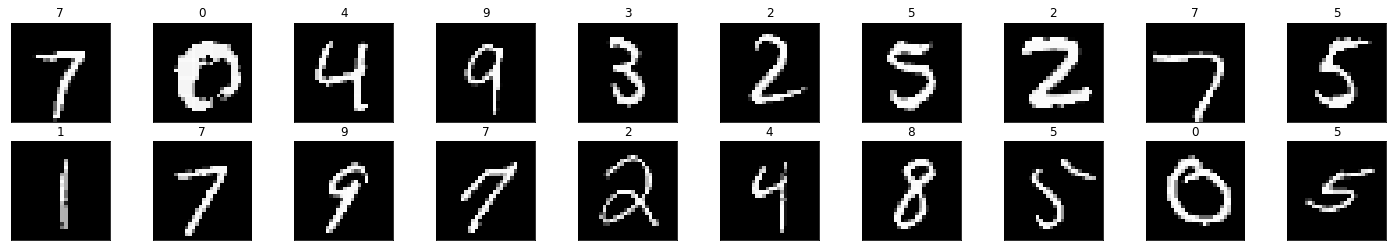

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(25, 4))

for i in np.arange(20):
  # row 2 column 10
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[i]))
    ax.set_title(labels[i].item())

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3*784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.float()
        h1 = F.relu(self.fc1(x.view(-1, 3*784)))
        h2 = F.relu(self.fc2(h1))
        h3 = F.relu(self.fc3(h2))
        h4 = F.relu(self.fc4(h3))
        h5 = F.relu(self.fc5(h4))
        h6 = self.fc6(h5)
        return F.log_softmax(h6, dim=1)

In [7]:


epochs = 12#학습 횟수
learning_rate = 0.01
momentum = 0.5
no_cuda = True
log_interval = 10

random_seed = 1

torch.manual_seed(random_seed)
use_cuda = not no_cuda and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

model = Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [8]:
#train
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item() 
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item() 
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

test()
for epoch in range(1, epochs+1):
    train(epoch)
    test()

C:\Users\dorit\anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 2.3088, Accuracy: 980/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297047
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.312973
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.305852
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.305152
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.302835
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.305681
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.289747
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.313604
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.314679
Train Epoch: 1 [9000/60000 (15%)]	Loss: 2.298019
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.297086
Train Epoch: 1 [11000/60000 (18%)]	Loss: 2.290447
Train Epoch: 1 [12000/60000 (20%)]	Loss: 2.291721
Train Epoch: 1 [13000/60000 (22%)]	Loss: 2.294620
Train Epoch: 1 [14000/60000 (23%)]	Loss: 2.293504
Train Epoch: 1 [15000/60000 (25%)]	Loss: 2.292327
Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.303794
Train Epoch: 1 [17000/60000 (28%)]	Loss: 2.291733
Train Epoch: 1 [18000/60000 (30%)]	Loss: 2.291524
Train Epo

Train Epoch: 3 [42000/60000 (70%)]	Loss: 0.325313
Train Epoch: 3 [43000/60000 (72%)]	Loss: 0.392405
Train Epoch: 3 [44000/60000 (73%)]	Loss: 0.517949
Train Epoch: 3 [45000/60000 (75%)]	Loss: 0.367225
Train Epoch: 3 [46000/60000 (77%)]	Loss: 0.358494
Train Epoch: 3 [47000/60000 (78%)]	Loss: 0.509040
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.444879
Train Epoch: 3 [49000/60000 (82%)]	Loss: 0.399392
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.276878
Train Epoch: 3 [51000/60000 (85%)]	Loss: 0.229042
Train Epoch: 3 [52000/60000 (87%)]	Loss: 0.454008
Train Epoch: 3 [53000/60000 (88%)]	Loss: 0.418283
Train Epoch: 3 [54000/60000 (90%)]	Loss: 0.333820
Train Epoch: 3 [55000/60000 (92%)]	Loss: 0.344377
Train Epoch: 3 [56000/60000 (93%)]	Loss: 0.401730
Train Epoch: 3 [57000/60000 (95%)]	Loss: 0.188271
Train Epoch: 3 [58000/60000 (97%)]	Loss: 0.542608
Train Epoch: 3 [59000/60000 (98%)]	Loss: 0.218433

Test set: Average loss: 0.3176, Accuracy: 9032/10000 (90%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.2

Train Epoch: 6 [24000/60000 (40%)]	Loss: 0.157619
Train Epoch: 6 [25000/60000 (42%)]	Loss: 0.126153
Train Epoch: 6 [26000/60000 (43%)]	Loss: 0.188090
Train Epoch: 6 [27000/60000 (45%)]	Loss: 0.063019
Train Epoch: 6 [28000/60000 (47%)]	Loss: 0.110472
Train Epoch: 6 [29000/60000 (48%)]	Loss: 0.079174
Train Epoch: 6 [30000/60000 (50%)]	Loss: 0.100554
Train Epoch: 6 [31000/60000 (52%)]	Loss: 0.225475
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.127338
Train Epoch: 6 [33000/60000 (55%)]	Loss: 0.088438
Train Epoch: 6 [34000/60000 (57%)]	Loss: 0.224839
Train Epoch: 6 [35000/60000 (58%)]	Loss: 0.060206
Train Epoch: 6 [36000/60000 (60%)]	Loss: 0.155761
Train Epoch: 6 [37000/60000 (62%)]	Loss: 0.171803
Train Epoch: 6 [38000/60000 (63%)]	Loss: 0.166466
Train Epoch: 6 [39000/60000 (65%)]	Loss: 0.142660
Train Epoch: 6 [40000/60000 (67%)]	Loss: 0.098767
Train Epoch: 6 [41000/60000 (68%)]	Loss: 0.113674
Train Epoch: 6 [42000/60000 (70%)]	Loss: 0.080788
Train Epoch: 6 [43000/60000 (72%)]	Loss: 0.127880


Train Epoch: 9 [6000/60000 (10%)]	Loss: 0.099003
Train Epoch: 9 [7000/60000 (12%)]	Loss: 0.095781
Train Epoch: 9 [8000/60000 (13%)]	Loss: 0.155524
Train Epoch: 9 [9000/60000 (15%)]	Loss: 0.069258
Train Epoch: 9 [10000/60000 (17%)]	Loss: 0.068739
Train Epoch: 9 [11000/60000 (18%)]	Loss: 0.101678
Train Epoch: 9 [12000/60000 (20%)]	Loss: 0.128308
Train Epoch: 9 [13000/60000 (22%)]	Loss: 0.117465
Train Epoch: 9 [14000/60000 (23%)]	Loss: 0.123692
Train Epoch: 9 [15000/60000 (25%)]	Loss: 0.076258
Train Epoch: 9 [16000/60000 (27%)]	Loss: 0.068585
Train Epoch: 9 [17000/60000 (28%)]	Loss: 0.090297
Train Epoch: 9 [18000/60000 (30%)]	Loss: 0.140350
Train Epoch: 9 [19000/60000 (32%)]	Loss: 0.047779
Train Epoch: 9 [20000/60000 (33%)]	Loss: 0.041243
Train Epoch: 9 [21000/60000 (35%)]	Loss: 0.100781
Train Epoch: 9 [22000/60000 (37%)]	Loss: 0.182649
Train Epoch: 9 [23000/60000 (38%)]	Loss: 0.091956
Train Epoch: 9 [24000/60000 (40%)]	Loss: 0.123055
Train Epoch: 9 [25000/60000 (42%)]	Loss: 0.140093
Trai

Train Epoch: 11 [47000/60000 (78%)]	Loss: 0.043202
Train Epoch: 11 [48000/60000 (80%)]	Loss: 0.037027
Train Epoch: 11 [49000/60000 (82%)]	Loss: 0.040758
Train Epoch: 11 [50000/60000 (83%)]	Loss: 0.047015
Train Epoch: 11 [51000/60000 (85%)]	Loss: 0.029384
Train Epoch: 11 [52000/60000 (87%)]	Loss: 0.029646
Train Epoch: 11 [53000/60000 (88%)]	Loss: 0.103072
Train Epoch: 11 [54000/60000 (90%)]	Loss: 0.099274
Train Epoch: 11 [55000/60000 (92%)]	Loss: 0.170745
Train Epoch: 11 [56000/60000 (93%)]	Loss: 0.055502
Train Epoch: 11 [57000/60000 (95%)]	Loss: 0.053045
Train Epoch: 11 [58000/60000 (97%)]	Loss: 0.145303
Train Epoch: 11 [59000/60000 (98%)]	Loss: 0.052914

Test set: Average loss: 0.1060, Accuracy: 9684/10000 (97%)

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.110495
Train Epoch: 12 [1000/60000 (2%)]	Loss: 0.032816
Train Epoch: 12 [2000/60000 (3%)]	Loss: 0.031429
Train Epoch: 12 [3000/60000 (5%)]	Loss: 0.071495
Train Epoch: 12 [4000/60000 (7%)]	Loss: 0.118075
Train Epoch: 12 [5000/60000 (8%)]	

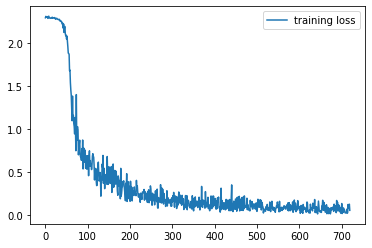

In [9]:
plt.plot(train_losses, label='training loss')
plt.legend()

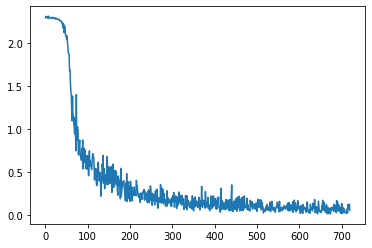

In [10]:
plt.plot(train_losses, label='training accuracy')

In [25]:
trans=transforms.Compose([transforms.Resize((28,28)),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                         ])
trainset = torchvision.datasets.ImageFolder(root=r"C:\Users\dorit\anaconda3\data\handwrite\examples",transform=trans)
trainloader=DataLoader(trainset,
                      batch_size=100,
                      shuffle=False,
                      num_workers=4)
dataiter=iter(trainloader)
images,labels=dataiter.next()
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)
print(labels)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [26]:
def imshow(img):
    img=img/2+0.5
    np_img=img.numpy()
    plt.imshow(np.transpose(np_img,(1,2,0)))
    
    print(np_img.shape)
    print((np.transpose(np_img,(1,2,0))).shape)

In [1]:
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

print(images.shape)
imshow(torchvision.utils.make_grid(images,nrow=4))



NameError: name 'images' is not defined

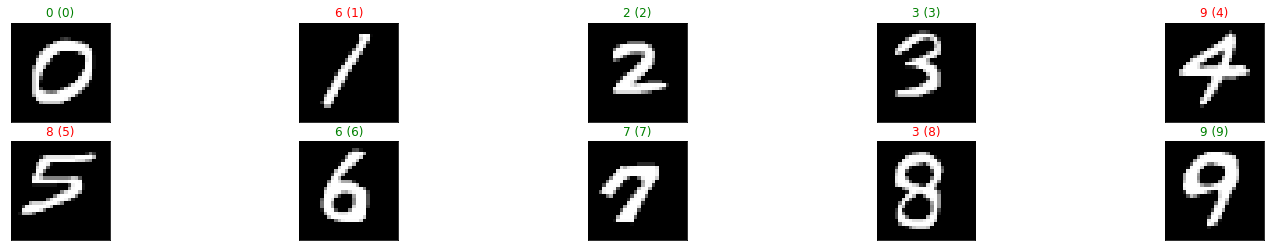

In [28]:
fig = plt.figure(figsize=(25, 4))

for i in np.arange(10):
    # row 2 column 10
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[i]))
    ax.set_title("{} ({})".format(str(preds[i].item()), str(labels[i].item())), color=('green' if preds[i] == labels[i] else 'red'))